In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
from numpy import exp
from scipy import ndimage
from func import *
from astropy.table import Table, hstack
import os
import glob
from astropy.table import Table, vstack, join
import pandas as pd
from shutil import copyfile
from scipy.optimize import leastsq

In [2]:
def flux_data_err(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdu = fits.open('%s/Flux Maps/%s/9_arcsec_fluxcube_%s.fits'%(destination_path_cube,obj,obj))
    (Hb_blr_br,OIII_br,OIII_nr) = (hdu[3].data,hdu[4].data,hdu[5].data)
    hdu.close()
    
    hdu = fits.open('%s/Flux Maps/%s/9_arcsec_fluxcube_err_%s.fits'%(destination_path_cube,obj,obj))
    (Hb_blr_br_err,OIII_br_err,OIII_nr_err) = (hdu[3].data,hdu[4].data,hdu[5].data)
    hdu.close()
    
    (amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr) = (np.max(Hb_blr_br),np.max(OIII_br),np.max(OIII_nr))
    
    return Hb_blr_br,OIII_br,OIII_nr,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err
    

In [3]:
def remove_bad_pixel(data,err):
    data[data == 0.01] = 0
    err[err < 10**(-14)] =10**(10)  
    return data,err

In [4]:
def ellip_moffat2D(p,xy,data,error):
    xy=(x,y)
    [amp, x0, y0, A, B, C, alpha] = p 
    g = amp*((1.0+A*(x-x0)**2+B*(y-y0)**2+C*(x-x0)*(y-y0))**(-alpha))
    h = (data - g)/error
    return h.ravel()

def ellip_moffat2D_fixkin(p,xy,data,error,fixed_param):
    [A,B,C,alpha] = fixed_param
    xy=(x,y)
    [amp, x0, y0] = p    
    g = amp*((1.0+(A*((x-x0)**2))+(B*((y-y0)**2))+(C*(x-x0)*(y-y0)))**(-alpha))
    h = (data - g)/error
    return h.ravel()

In [5]:
def elliptical_moffat_fit(data,error,box_size,amp,x0,y0,fix_par,MC_loops=100):
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    
    if fix_par is None:
        p= [amp,x0,y0,0.1,0.1,-0.00008,3]
        popt,pcov = leastsq(ellip_moffat2D,x0=p,args=(xy,data,error),maxfev = 10000000)
        [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out]= popt
        theta_out = 0.5*np.arctan(C_out/(A_out - B_out))
        a_out = np.sqrt(2/(A_out + B_out + np.sqrt(C_out**2 +(A_out - B_out)**2)))
        b_out = np.sqrt(2/(A_out + B_out - np.sqrt(C_out**2 +(A_out - B_out)**2)))
        [fwhm1_out,fwhm2_out] = [2*a_out*np.sqrt(2**(1/alpha_out)-1),2*b_out*np.sqrt(2**(1/alpha_out)-1)]
        par = [amp_out,x0_out,y0_out,A_out,B_out,C_out,alpha_out,a_out,b_out,theta_out,fwhm1_out,fwhm2_out]
        mod_rav = data.ravel() - ellip_moffat2D(popt,xy,data,error)*error.ravel()
    else:
        p= [amp,x0,y0]
        popt,pcov = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,data,error,fix_par),maxfev = 10000000)
        [amp_out,x0_out,y0_out]= popt
        par = popt
        mod_rav = data.ravel() - ellip_moffat2D_fixkin(popt,xy,data,error,fix_par)*error.ravel()
    model = mod_rav.reshape(box_size,box_size)
    residual = data-model
    res = (residual/error)

    parameters_MC = np.zeros((len(par),MC_loops))
    for l in range(MC_loops):
        iteration_data = np.random.normal(data,error) 
        if fix_par is None:
            p= [amp,x0,y0,0.1,0.1,-0.00008,3]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D,x0=p,args=(xy,iteration_data,error),maxfev = 10000000)
            [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC]= popt_MC
            theta_MC = 0.5*np.arctan(C_MC/(A_MC - B_MC))
            a_MC = np.sqrt(2/(A_MC + B_MC + np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            b_MC = np.sqrt(2/(A_MC + B_MC - np.sqrt(C_MC**2 +(A_MC - B_MC)**2)))
            [fwhm1_MC,fwhm2_MC] = [2*a_MC*np.sqrt(2**(1/alpha_MC)-1),2*b_MC*np.sqrt(2**(1/alpha_MC)-1)]
            par_MC = [amp_MC,x0_MC,y0_MC,A_MC,B_MC,C_MC,alpha_MC,a_MC,b_MC,theta_MC,fwhm1_MC,fwhm2_MC]   
            parameters_MC[:,l] = par_MC    
        else:
            p= [amp,x0,y0]
            popt_MC,pcov_MC = leastsq(ellip_moffat2D_fixkin,x0=p,args=(xy,iteration_data,error,fix_par),maxfev = 10000000)
            [amp_MC,x0_out,y0_out]= popt_MC
            parameters_MC[:,l] = popt_MC    
    parameters_err = np.std(parameters_MC,1) 
    return par,parameters_err,model,res

In [6]:
def chi_squared(data,model,err):
    res = data - model
    a = np.sum((res/err)**2)
    return a

def red_chi_squared(data,model,err,n_free):
    dof = len(data.flatten()) - n_free
    res = data - model
    k = res/err
    k[k>10**10]=0
    l = k[k!=0]
    a = np.sum(l**2)
    red = a/dof
    return red


In [7]:
def moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    column_names={'amp_Hb_blr':0,'x0_Hb_Blr':1,'y0_Hb_Blr':2,'A':3,'B':4,'C':5,'alpha':6,'a':7,'b':8,'theta':9,'fwhm1':10,'fwhm2':11,'amp_OIII_br':12,'x0_OIII_br':13,'y0_OIII_br':14,'amp_OIII_nr':15,'x0_OIII_nr':16,'y0_OIII_nr':17}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[full_data[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[full_error[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/9_arcsec_moffat_table_flux_mod_%s.fits'%(destination_path_cube,obj,obj),overwrite=True)

def maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    hdus=[]
    hdus.append(fits.PrimaryHDU())
    hdus.append(fits.ImageHDU(Hb_blr_br_data,name='Hb_blr_br_data'))
    hdus.append(fits.ImageHDU(OIII_br_data,name='OIII_br_data'))
    hdus.append(fits.ImageHDU(OIII_nr_data,name='OIII_nr_data'))
    hdus.append(fits.ImageHDU(Hb_model,name='Hb_blr_br_model'))
    hdus.append(fits.ImageHDU(OIII_br_model,name='OIII_br_model'))   
    hdus.append(fits.ImageHDU(OIII_nr_model,name='OIII_nr_model'))
    hdus.append(fits.ImageHDU(Hb_res,name='Hb_blr_br_res'))
    hdus.append(fits.ImageHDU(OIII_br_res,name='OIII_br_res'))
    hdus.append(fits.ImageHDU(OIII_nr_res,name='OIII_nr_res'))
    hdu = fits.HDUList(hdus)
    hdu.writeto('%s/%s/9_arcsec_maps_flux_mod_%s.fits'%(destination_path_cube,obj,obj),overwrite='True')

def fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    f_blr_data = np.sum(Hb_blr_br_data)
    f_wing_data = np.sum(OIII_br_data)
    f_blr_model = np.sum(Hb_model)
    f_wing_model = np.sum(OIII_br_model)
    f_blr_err = np.sqrt(np.sum(Hb_blr_br_err**2))
    f_wing_err = np.sqrt(np.sum(OIII_br_err**2))
    tab_par = [f_blr_data,f_wing_data,f_blr_model,f_wing_model]
    tab_err = [f_blr_err,f_wing_err,0,0]
    column_names={'flux_blr_data':0,'flux_wing_data':1,'flux_blr_model':2,'flux_wing_model':3}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[tab_par[column_names[key]]]))
        columns.append(fits.Column(name=key+'_err',format='E',array=[tab_err[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def fluxden_comp_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_3_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_fluxden_HbOIII.fits'%(destination_path_cube,obj,obj),overwrite=True)
    
def emp_table(obj,emp_blr,emp_wing,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    popt = [emp_blr,emp_wing]
    column_names={'emp_fact_blr':0,'emp_fact_wing':1}
    columns=[]
    for key in column_names.keys():
        columns.append(fits.Column(name=key,format='E',array=[popt[column_names[key]]]))
    coldefs = fits.ColDefs(columns)
    hdu = fits.BinTableHDU.from_columns(coldefs)
    hdu.writeto('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

def emp_fact_table(obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):
    t1 = Table.read('%s/%s/source_%s.fits'%(destination_path_cube,obj,obj),format='fits')
    t2 = Table.read('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),format='fits')
    new = hstack([t1, t2])
    new.write('%s/%s/%s_9_arcsec_scaling_subcube.fits'%(destination_path_cube,obj,obj),overwrite=True)

In [8]:
def algorithm_script(obj,z,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE"):  
    print ('%s'%(obj))
    (Hb_blr_br_dat,OIII_br_dat,OIII_nr_dat,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_error,OIII_br_error,OIII_nr_error) = flux_data_err(obj)
    (Hb_blr_br_data,Hb_blr_br_err) = remove_bad_pixel(Hb_blr_br_dat,Hb_blr_br_error)
    (OIII_br_data,OIII_br_err) = remove_bad_pixel(OIII_br_dat,OIII_br_error)
    (OIII_nr_data,OIII_nr_err) = remove_bad_pixel(OIII_nr_dat,OIII_nr_error)  
    box_size = np.shape(Hb_blr_br_data)[0]
    (brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y) = brightest_pixel_flux_map(Hb_blr_br_data,OIII_br_data,OIII_nr_data) 
    print ((brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y)
    (Hb_par,Hb_error,Hb_model,Hb_res) = elliptical_moffat_fit(Hb_blr_br_data,Hb_blr_br_err,box_size,amp_Hb_blr_br,brightest_pixel_Hb_blr_br_x,brightest_pixel_Hb_blr_br_y,None,100)
    print (Hb_par,Hb_error)
    red_chi_sq_Hb = red_chi_squared(Hb_blr_br_data,Hb_model,Hb_blr_br_err,5)   
    #print (red_chi_sq_Hb)
    fixed_param = [Hb_par[3],Hb_par[4],Hb_par[5],Hb_par[6]]
    (OIII_br_par,OIII_br_error,OIII_br_model,OIII_br_res) = elliptical_moffat_fit(OIII_br_data,OIII_br_err,box_size,amp_OIII_br,brightest_pixel_OIII_br_x,brightest_pixel_OIII_br_y,fixed_param,100)   
    print (OIII_br_par,OIII_br_error)
    (OIII_nr_par,OIII_nr_error,OIII_nr_model,OIII_nr_res) = elliptical_moffat_fit(OIII_nr_data,OIII_nr_err,box_size,amp_OIII_nr,brightest_pixel_OIII_nr_x,brightest_pixel_OIII_nr_y,fixed_param,100)   
    print (OIII_nr_par,OIII_nr_error)

    (full_data,full_error) = (np.append(Hb_par,[OIII_br_par,OIII_nr_par]),np.append(Hb_error,[OIII_br_error,OIII_nr_error]))
    moffat_table(full_data,full_error,obj,destination_path_cube="/home/mainak/Downloads/Outflow_paper1/MUSE")
    maps(Hb_blr_br_data,OIII_br_data,OIII_nr_data,Hb_model,OIII_br_model,OIII_nr_model,Hb_res,OIII_br_res,OIII_nr_res,obj)
    fluxden_compare(obj,Hb_blr_br_data,OIII_br_data,Hb_model,OIII_br_model,Hb_blr_br_err,OIII_br_err)
    
        
    plt.imshow(Hb_blr_br_data,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(Hb_model,origin='lower')
    plt.plot(Hb_par[1],Hb_par[2],'kx')
    plt.show()
    plt.imshow(OIII_br_data,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_br_model,origin='lower')
    plt.plot(OIII_br_par[1],OIII_br_par[2],'bx')
    plt.show()
    plt.imshow(OIII_nr_data,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    plt.imshow(OIII_nr_model,origin='lower')
    plt.plot(OIII_nr_par[1],OIII_nr_par[2],'gx')
    plt.show()
    

HE0021-1819
21 22
[3.638393679029922, 21.636530489243416, 22.12966560613847, 0.07591180263586213, 0.08006966967654329, -0.012298615982620071, 2.6750610450856995, 3.440471908231102, 3.739800646523241, 0.6223917260861204, 3.7422606169453863, 4.067845646763738] [0.09119908 0.02133562 0.02141682 0.00547423 0.00574022 0.00222468
 0.09873206 0.11978472 0.1321956  0.20994867 0.06118175 0.06841081]
[ 4.59120656 21.38297882 22.28159884] [0.02117884 0.00893964 0.00989386]
[ 6.67833004 21.47278856 21.96435185] [0.02071488 0.00664534 0.00819438]


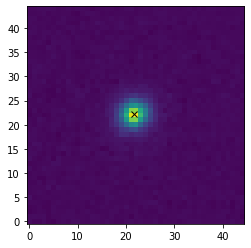

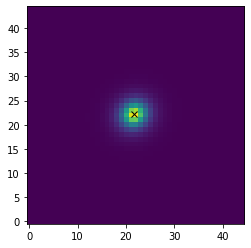

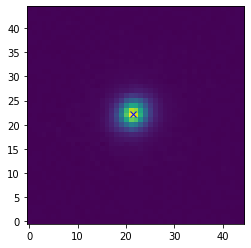

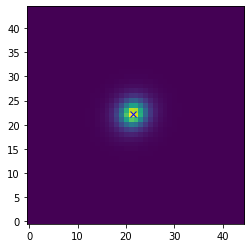

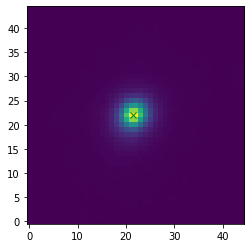

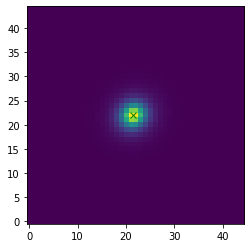

HE0040-1105
21 22
[18.000223907210184, 21.645833332795696, 21.80763209810047, 0.08592927644197856, 0.09651115614502065, -0.0005288546189671803, 2.652826028312567, 3.218817720317929, 3.4115057745251023, 0.024967915861090026, 3.5177978168440442, 3.7283837136915894] [0.12479026 0.00628336 0.00690658 0.00178122 0.00210083 0.00079802
 0.02863564 0.03510528 0.03519959 0.03832136 0.01902643 0.01804599]
[ 6.7844768  22.18635235 21.6709293 ] [0.03780784 0.01038908 0.00928171]
[15.04828785 21.4944126  22.02385137] [0.04081915 0.00662601 0.00673714]


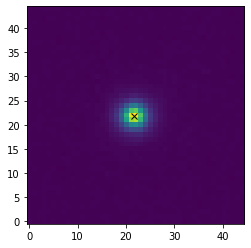

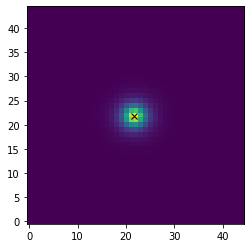

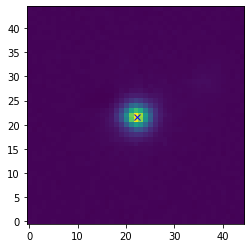

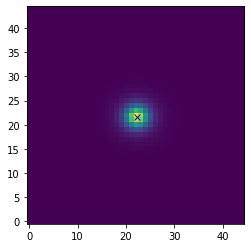

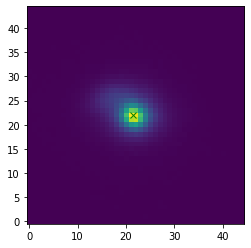

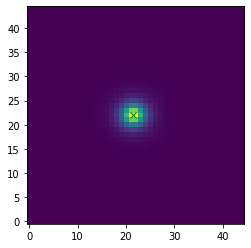

HE0108-4743
10 11
[40.42814182316854, 11.030640443000582, 11.09043107407607, 0.05024468961109499, 0.05029145860249243, 0.00161681060759247, 4.084782466537192, 4.424743348443685, 4.496513303545364, -0.7709388466994366, 3.805666090702885, 3.8673945262194445] [1.46572586e+00 2.37246036e-02 2.28740019e-02 5.72112171e-03
 5.66628634e-03 1.34797510e-03 2.86068156e-01 2.42525685e-01
 2.52216211e-01 5.50474717e-01 7.47706767e-02 7.78137590e-02]
[15.27133013 10.75225046 11.16232793] [0.21018396 0.02314934 0.04858264]
[22.61372204 10.17435694 11.09214437] [0.39368465 0.04786136 0.02830366]


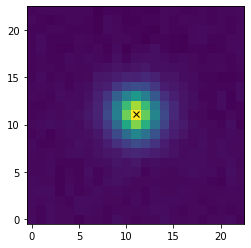

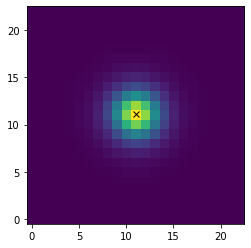

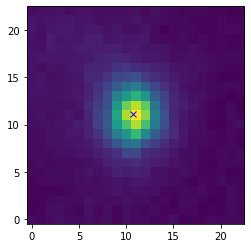

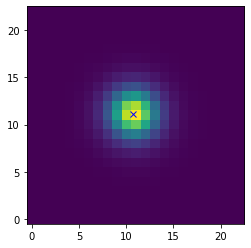

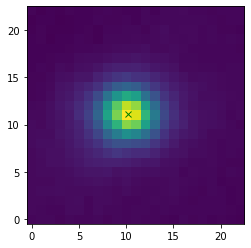

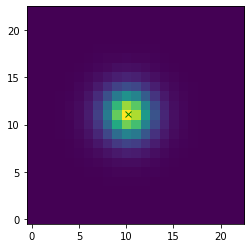

HE0114-0015
22 22
[6.098052590185072, 21.660051056531092, 21.384414366788278, 0.09878394668672585, 0.11660369476175869, -0.015437255218885447, 3.132769992572484, 2.893001187862832, 3.22907479714498, 0.35694075447513535, 2.879337040480564, 3.213823315700152] [0.19166216 0.02638882 0.02825497 0.01009371 0.01255442 0.00525661
 0.22135425 0.16301735 0.17118334 0.10535308 0.06213384 0.06431091]
[ 1.04338184 21.82572039 22.12593485] [0.07869811 0.10660962 0.2072588 ]
[ 3.28248833 21.7344733  21.54580073] [0.06191934 0.03078272 0.03142717]


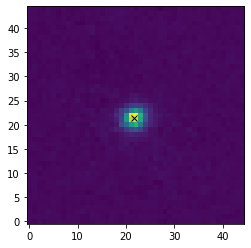

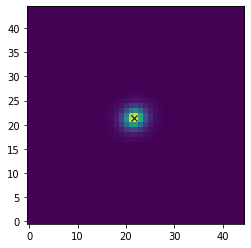

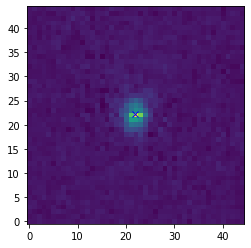

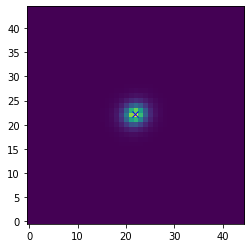

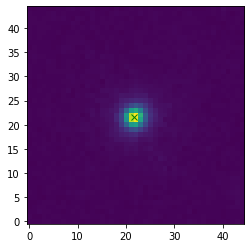

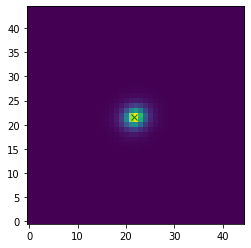

HE0119-0118
11 11
[233.71609102426046, 11.150366002637137, 11.031759391267062, 0.26476820517020105, 0.2580904482929997, -0.0054002321139307394, 2.8924717580086927, 1.9399258536331654, 1.972055604264684, -0.34000851333548465, 2.0189754269491758, 2.0524144250828162] [5.04614485e+00 8.80364932e-03 9.58500151e-03 1.11835982e-02
 1.11968924e-02 3.83802897e-03 6.20468765e-02 4.05439586e-02
 4.33769330e-02 2.07804725e-01 2.07210779e-02 2.32075746e-02]
[106.16668163  11.03108024  10.99262891] [0.33090519 0.00352178 0.0034985 ]
[78.34844361 11.10133312 11.00405845] [0.3478103  0.0053503  0.00440472]


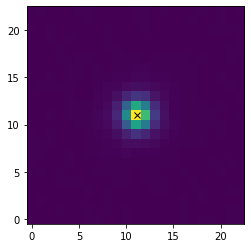

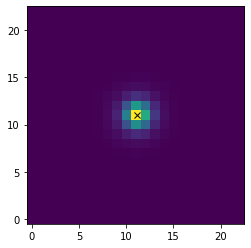

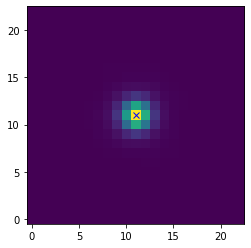

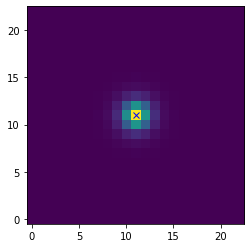

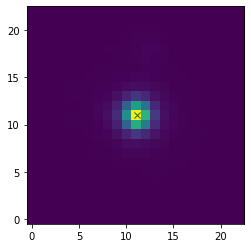

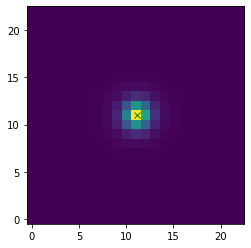

HE0212-0059
22 22
[38.56922614008823, 22.388525611692796, 21.695089866430102, 0.08763040766635007, 0.08643030324417617, -0.001468461075279942, 2.143954982394862, 3.371409376832029, 3.4083448686733004, -0.44281167880552247, 4.1657525207850075, 4.21139044280704] [3.14595666e+00 3.54898895e-02 3.28145859e-02 7.85148812e-03
 7.61802971e-03 1.85089397e-03 4.25143401e-02 1.48259059e-01
 1.50125124e-01 4.50635445e-01 1.39428539e-01 1.41646253e-01]
[ 2.92588097 22.31170686 22.66850268] [0.08440455 0.06011955 0.10890302]
[15.2858352  22.3197624  21.55883719] [0.04130459 0.00626792 0.00753271]


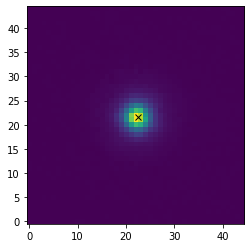

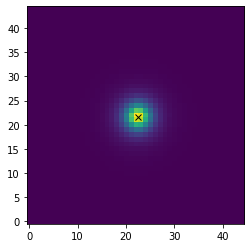

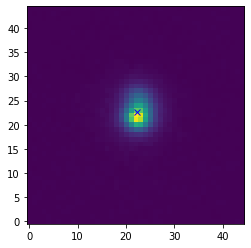

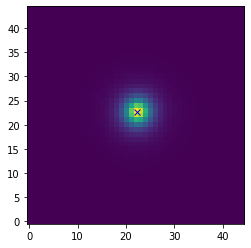

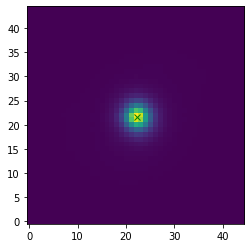

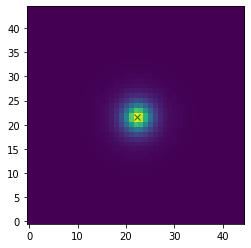

HE0224-2834
11 11
[31.357877074049984, 10.900677856658588, 10.982684256167211, 0.05859132796937994, 0.05749277763227688, -0.0033842369857510564, 3.0425750097477042, 4.08858324184426, 4.215882434219718, -0.6284595179102801, 4.136176923855081, 4.264957958943228] [0.32126119 0.00896116 0.00893695 0.00198858 0.00201754 0.00062578
 0.0617518  0.07134316 0.07392256 0.24797736 0.02902295 0.03028453]
[11.16513912 10.96647336 10.89352596] [0.088117   0.01683312 0.01922851]
[17.32738169 10.01617326 11.31048042] [0.11292576 0.01676685 0.01244533]


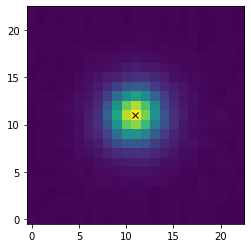

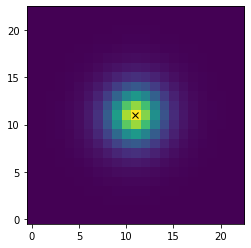

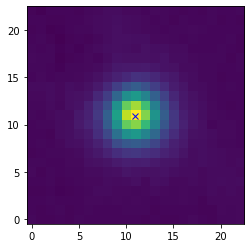

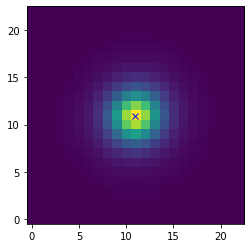

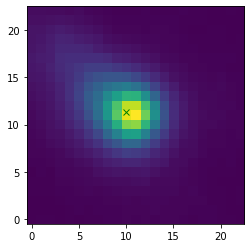

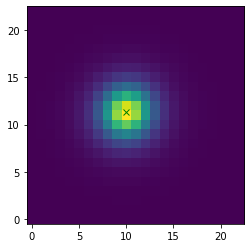

HE0227-0913
11 11
[302.38769989218247, 11.01168483139356, 11.096367782998273, 0.13204664550499032, 0.12838368066577416, -0.0021395296588099656, 2.4961284665557795, 2.7489111211955035, 2.7940576529382306, -0.26432231435668996, 3.11040460423657, 3.1614880965747365] [1.76294520e+00 3.37735720e-03 3.54449174e-03 1.56150344e-03
 1.59249009e-03 6.35343830e-04 1.33974781e-02 1.63769771e-02
 1.72633411e-02 7.98268266e-02 1.02860954e-02 1.08734296e-02]
[ 8.3513981  11.08432172 11.13737391] [0.09637717 0.02059391 0.02071055]
[39.53723065 11.02878182 11.19641665] [0.09878408 0.00437287 0.0054375 ]


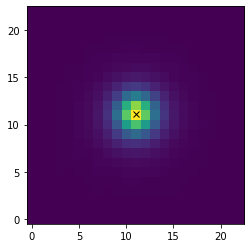

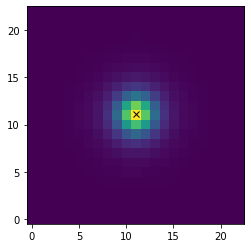

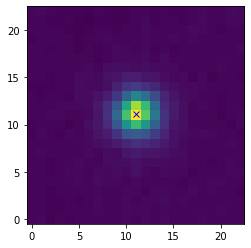

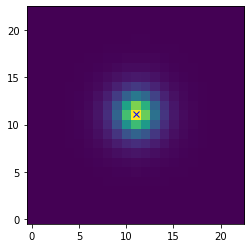

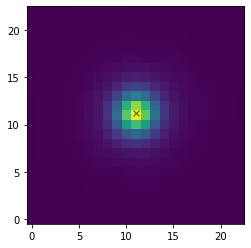

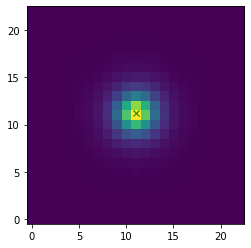

HE0232-0900
11 11
[703.9441139860961, 11.103321867905294, 11.121660859534774, 0.13860455676314046, 0.13650948571083857, -0.0013395382952650823, 2.5107207869950106, 2.684137037530142, 2.7085090693266403, -0.2844352182059548, 3.026995838485656, 3.054481036816411] [8.99494787e+00 5.36966340e-03 4.67258867e-03 2.59406391e-03
 2.53784912e-03 6.88328351e-04 1.72737461e-02 2.51114943e-02
 2.49562736e-02 1.35472938e-01 1.77093271e-02 1.73729751e-02]
[274.05391216  10.6184664   10.95653127] [1.61732928 0.01270441 0.01055243]
[328.45078338  11.01525499  10.3291185 ] [1.60064577 0.00798815 0.01244455]


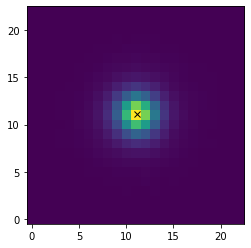

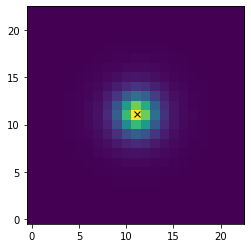

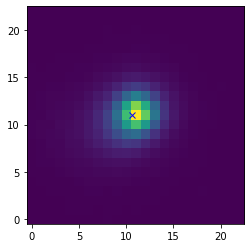

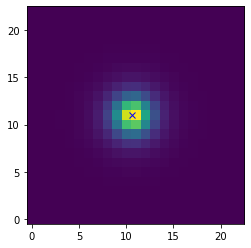

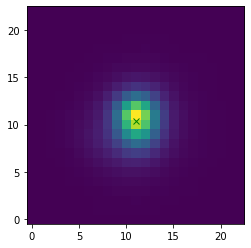

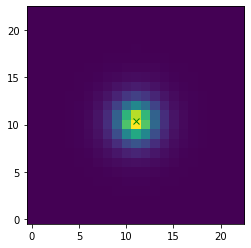

HE0253-1641
11 11
[186.05098584814027, 11.083518025540767, 10.776902211641424, 0.17021038355014678, 0.16172596602068182, 0.01216840874872328, 2.952188927349784, 2.4015622691753533, 2.511397464777269, 0.4809593439708747, 2.470899906210502, 2.5839062512862747] [2.80717603e+00 6.83284117e-03 7.19494110e-03 6.64980965e-03
 5.96093517e-03 2.26333301e-03 5.42091912e-02 4.48633586e-02
 4.77990242e-02 7.10947915e-02 2.30963776e-02 2.42750881e-02]
[114.45942543  10.99827051  10.80253851] [0.44722251 0.00539434 0.00510943]
[113.34877758  10.9420605   10.51960999] [0.38426281 0.00429122 0.00510974]


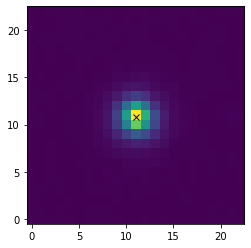

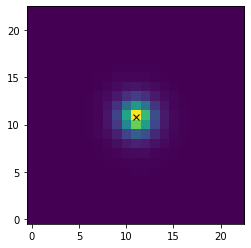

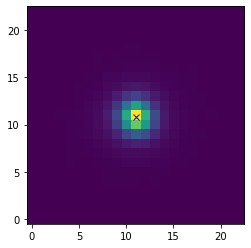

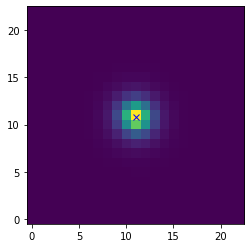

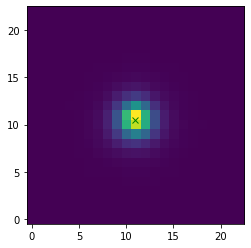

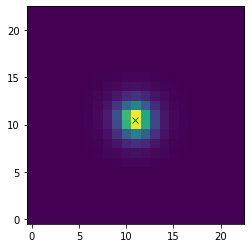

HE0345+0056
11 11
[1063.2367246206618, 11.099021765860515, 11.049001551736273, 0.24646730738290643, 0.23420957340983226, 0.005346368558855589, 2.394798174167687, 2.0120076234199074, 2.068784621286244, 0.20564379360514837, 2.331421199579085, 2.3972117537167663] [8.88937270e+00 3.26715524e-03 3.48001906e-03 2.97859573e-03
 2.90275674e-03 1.04162731e-03 1.03313533e-02 1.23000442e-02
 1.27854401e-02 3.75811713e-02 9.25180440e-03 9.52750161e-03]
[207.40936753  11.09891513  11.01066751] [0.7855954  0.00479463 0.00551289]
[182.33187965  11.08354208  10.9299948 ] [0.81236981 0.00723026 0.00823674]


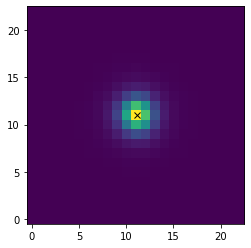

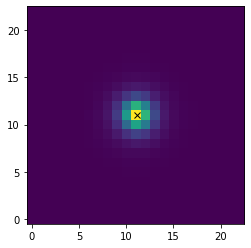

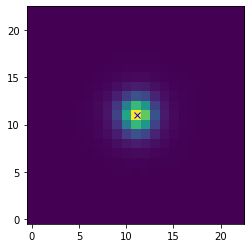

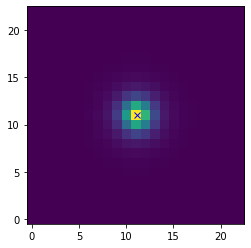

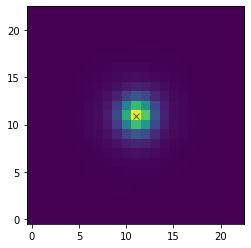

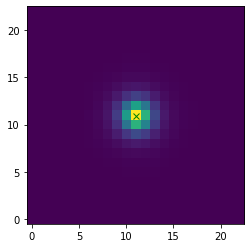

HE0351+0240
11 11
[230.668884528158, 10.939546608528728, 10.718687673495111, 0.2578694704137393, 0.2307545308166048, -0.002601621814179383, 2.8325553170407782, 1.9690085971749964, 2.0820132063337122, -0.04782754730356352, 2.073535294420492, 2.192538860915314] [1.92997210e+00 3.93315646e-03 3.95332227e-03 6.75991270e-03
 6.10308078e-03 1.58962581e-03 4.07425006e-02 2.58216553e-02
 2.76446161e-02 2.91170687e-02 1.14018440e-02 1.26575930e-02]
[31.06172667 10.91414028 10.71356336] [0.43693824 0.02071758 0.01847199]
[135.58278228  10.96513323  10.70641053] [0.37563404 0.0026074  0.00302028]


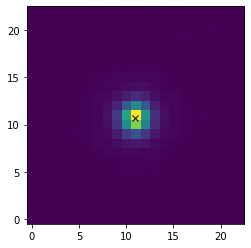

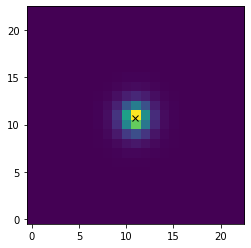

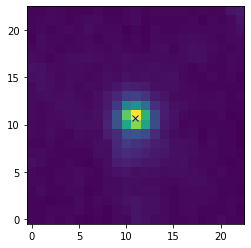

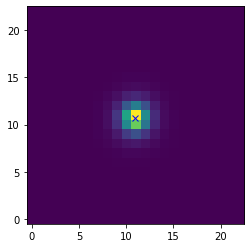

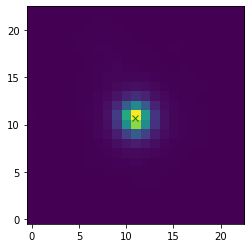

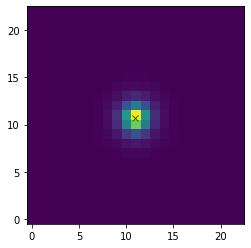

HE0412-0803
22 22
[125.45959928934808, 21.944809946676735, 21.940558355072447, 0.09496683648296786, 0.09789196124449466, 0.011741105009567711, 2.3240974898089974, 3.123789204527929, 3.3263295268357136, -0.6633157903927366, 3.6828400798919327, 3.9216281567916553] [5.28262587e-01 3.19592393e-03 3.53068411e-03 7.00368426e-04
 7.42122134e-04 2.61962848e-04 6.80564421e-03 1.14849711e-02
 1.25409575e-02 1.18843313e-02 8.14031723e-03 8.97725026e-03]
[68.70723315 22.09794119 22.00367176] [0.17998242 0.00765481 0.00783954]
[316.85131653  22.30220865  22.20962845] [0.45782032 0.00535433 0.0073402 ]


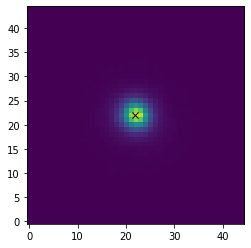

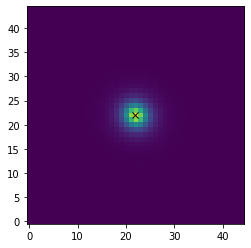

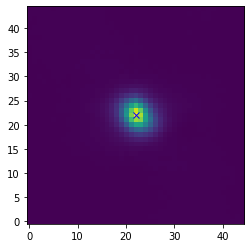

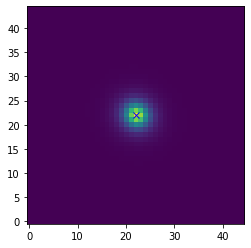

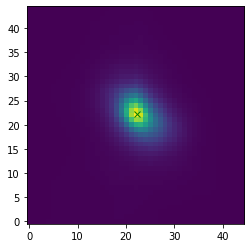

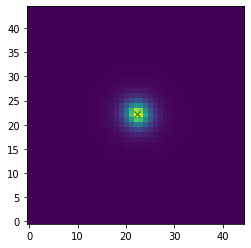

HE0429-0247
11 11
[129.8412559847393, 11.033896870058733, 10.83999566183673, 0.17784297411238614, 0.16655404628393497, -0.002063047428689708, 2.6841565203226097, 2.370650505895517, 2.4510056799812134, -0.09037749872724408, 2.5736355055813354, 2.660871025355262] [0.79819147 0.00327674 0.00342222 0.00263539 0.00236784 0.00089768
 0.01850194 0.01751754 0.01747204 0.03901539 0.00990892 0.009781  ]
[20.08501367 11.248257   10.78416138] [0.08273204 0.00612872 0.00517277]
[45.50760416 10.78165835 10.88488562] [0.0693739  0.00299448 0.00283057]


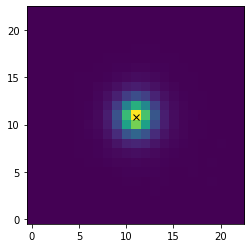

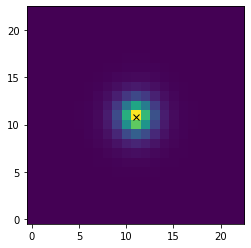

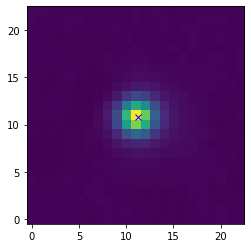

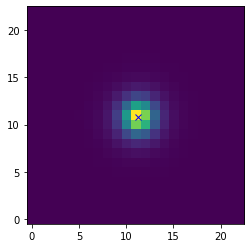

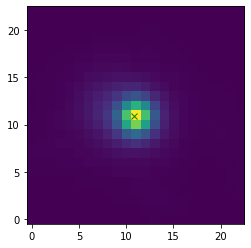

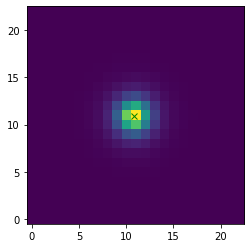

HE0433-1028
22 22
[192.63265055324726, 21.805396549794764, 22.10794188526897, 0.12409769899065312, 0.12469628117393848, 0.001998133821653614, 2.4299125176852594, 2.823463058952162, 2.847234789670043, -0.6398667537662543, 3.2444159384776747, 3.2717318198672882] [4.16794209e+00 6.89366070e-03 7.64448660e-03 2.83317373e-03
 2.85082447e-03 6.68669448e-04 1.48356964e-02 3.19076585e-02
 3.27347498e-02 5.69001247e-01 2.66206312e-02 2.76986935e-02]
[71.85155786 21.89018268 22.02971646] [0.05044686 0.00139255 0.00139479]
[30.93802382 21.82350235 22.19233371] [0.05711699 0.00355184 0.00367029]


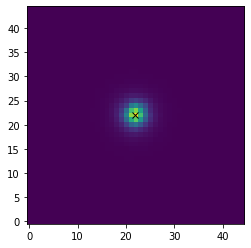

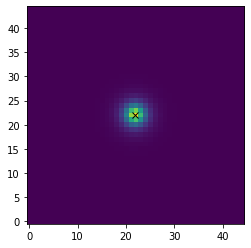

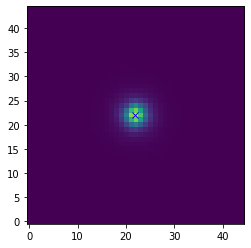

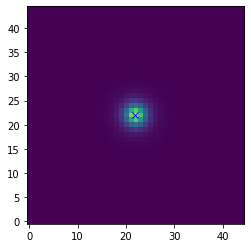

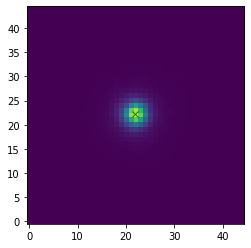

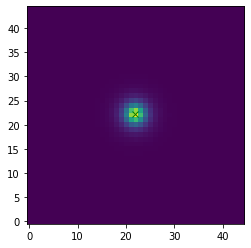

HE0853+0102
22 22
[14.525280275630632, 21.929168227875127, 22.322014443931337, 0.14820638817631954, 0.1349302979267048, -0.008997446157638858, 2.90464720204183, 2.585549017906872, 2.7363956923511594, -0.29780729792702454, 2.6845601670672092, 2.841183371942869] [0.37607277 0.0141449  0.01261605 0.0094928  0.00857694 0.00245837
 0.09572878 0.08280704 0.08853313 0.08105912 0.04042292 0.04332365]
[ 4.5957582  21.96776643 22.24255834] [0.03249058 0.01146311 0.01334142]
[ 5.79292424 22.15187234 22.53391733] [0.02492328 0.00781112 0.00746799]


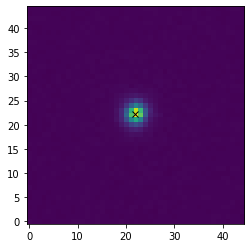

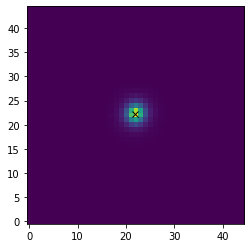

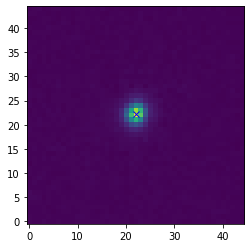

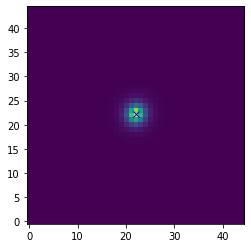

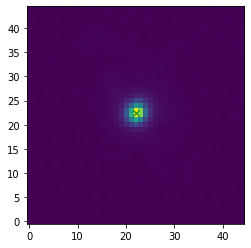

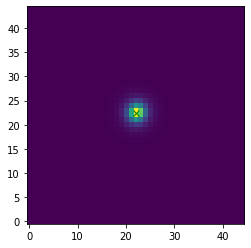

HE0934+0119
22 22
[46.343547918907056, 21.537922694075444, 21.529443827416625, 0.09819344169845272, 0.09858859939251978, 0.0007929159959838469, 2.3274842633651485, 3.1808768076482714, 3.1952297154328737, -0.5542307495824941, 3.7469882317528556, 3.7638955751718233] [3.35667516e-01 5.08789510e-03 5.86897749e-03 1.40819463e-03
 1.39146787e-03 4.74665024e-04 1.33099801e-02 2.29813667e-02
 2.24581351e-02 4.97713176e-01 1.59800847e-02 1.50029915e-02]
[ 7.15714144 21.63245055 21.4059583 ] [0.01954066 0.00671036 0.00604314]
[ 7.50722592 21.40346    21.60954836] [0.02187852 0.00630151 0.00812623]


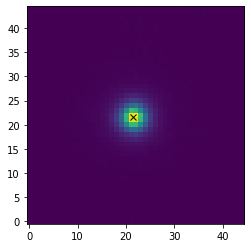

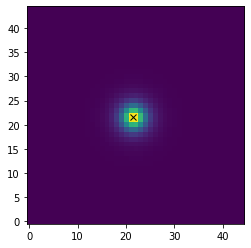

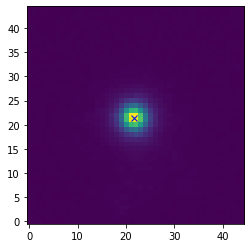

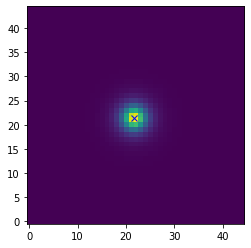

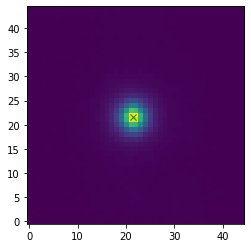

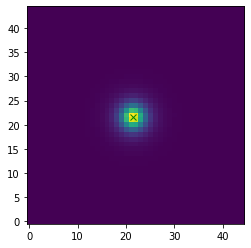

HE1011-0403
22 22
[49.073186606952824, 21.786112555513927, 21.808998181604103, 0.08213293875014689, 0.07998310796508211, -0.0016217825284403633, 2.432370069914017, 3.483570042092315, 3.5419250762748455, -0.32314819943768164, 4.000614274440836, 4.067630576658172] [2.46473746e+00 3.49302692e-02 3.32019605e-02 4.73842568e-03
 4.43350578e-03 1.69822167e-03 3.96600469e-02 9.94057825e-02
 1.00478483e-01 3.15001527e-01 8.10816959e-02 8.34394933e-02]
[ 6.39049962 21.84685911 21.81292284] [0.02537058 0.00812602 0.00874662]
[ 6.73136367 21.75315091 21.79551085] [0.01992925 0.00678248 0.0070147 ]


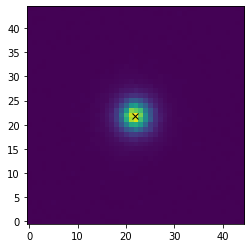

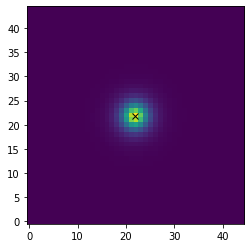

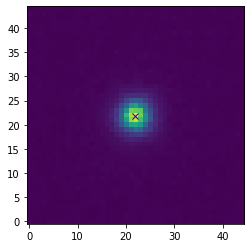

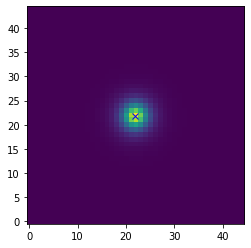

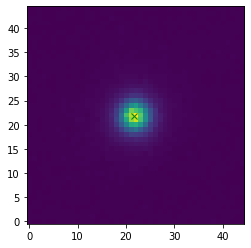

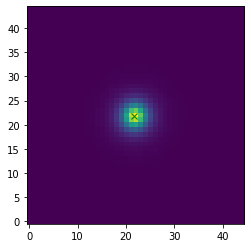

HE1017-0305
22 22
[55.95682457608591, 22.159889478418126, 21.989324835043448, 0.07990217736626082, 0.08758048479853943, 0.0023470946875682923, 2.5755590861344646, 3.3756854831310834, 3.5415859346515157, -0.14832919642658468, 3.751835027002992, 3.9362216140000243] [0.44233733 0.00627901 0.0058637  0.00178914 0.00198375 0.00064131
 0.02999434 0.0374744  0.03993552 0.04019005 0.01925732 0.02111873]
[ 4.85636411 22.21326542 21.79037252] [0.0682388  0.03450207 0.03466351]
[ 2.62474299 22.19623543 22.13933239] [0.0482497  0.03612226 0.0343886 ]


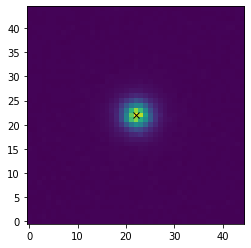

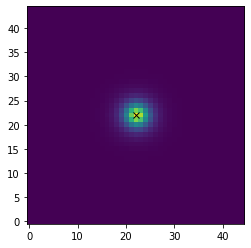

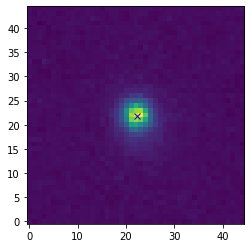

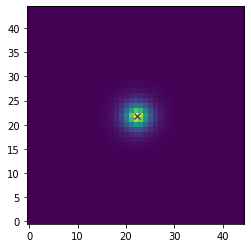

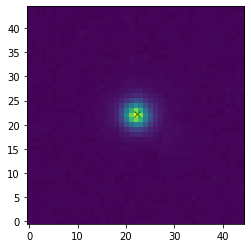

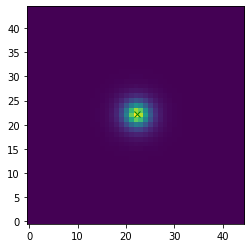

HE1029-1831
22 22
[32.51240694839768, 21.942660083606796, 22.172406474542623, 0.06298212912444642, 0.06364820455087981, -0.0008345981113519468, 3.203511741883608, 3.957516296938015, 3.9910298278657796, 0.4486138387645248, 3.890163783152388, 3.923106951159458] [0.43784501 0.01133171 0.01276793 0.00241724 0.00253449 0.00083245
 0.06959275 0.07997494 0.0758055  0.43840618 0.03506469 0.030764  ]
[16.37746186 21.61066453 22.53929025] [0.03547815 0.00622062 0.00697144]
[ 1.28839867 22.51553927 21.78709319] [0.02239286 0.02184873 0.03550296]


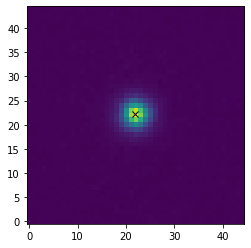

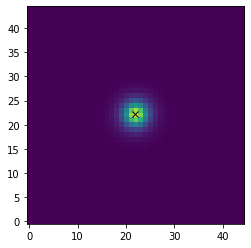

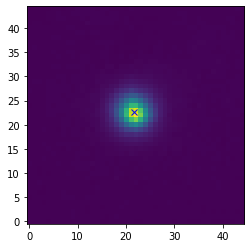

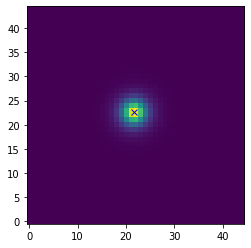

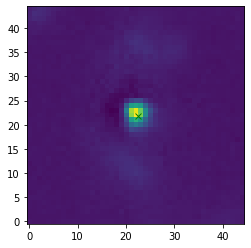

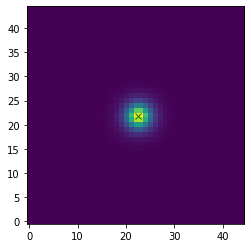

HE1107-0813
22 22
[112.27831821404034, 21.93594065405689, 21.923198092390628, 0.1023160211120176, 0.10113779366154374, -0.010609982619894173, 2.574314215792383, 3.0561680823702884, 3.2209617921913116, -0.7301002535659764, 3.397650771675987, 3.5808578009524967] [8.55059302e-01 4.22606181e-03 4.89288949e-03 1.21370987e-03
 1.17733378e-03 4.47855920e-04 1.11733580e-02 1.85697841e-02
 1.83409472e-02 1.51352792e-01 1.34208790e-02 1.24721461e-02]
[ 2.78215816 22.02752378 22.04188413] [0.04116183 0.02639706 0.02710133]
[ 1.66969625 21.7757995  21.75550481] [0.0207595  0.0384047  0.02493862]


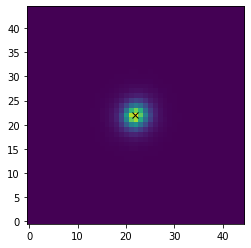

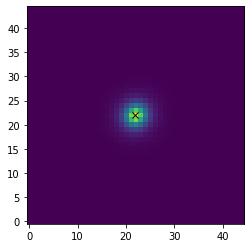

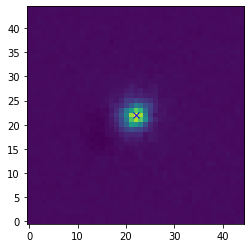

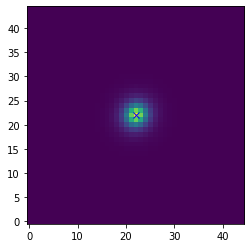

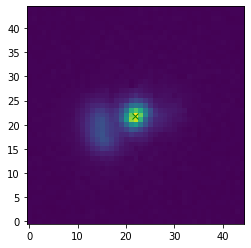

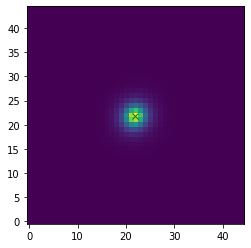

HE1108-2813
22 22
[87.51218713440097, 21.898848965726014, 22.44812482359083, 0.21705182118118332, 0.2172459149857726, 0.013188658067451491, 2.44631802109952, 2.1140944555074324, 2.1793070928460256, -0.7780403339269814, 2.4199151440561097, 2.4945613114817857] [0.87291772 0.00689562 0.00630672 0.00546023 0.00577124 0.0022948
 0.03172261 0.02639915 0.02955586 0.70621897 0.01442095 0.01746769]
[26.11377061 22.18439694 22.44534027] [0.20510244 0.01583801 0.01442567]
[17.25903744 22.24390579 22.38005422] [0.16822673 0.0182262  0.01506662]


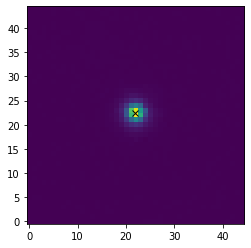

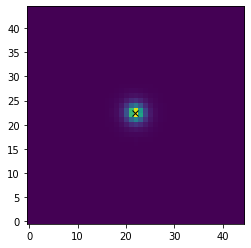

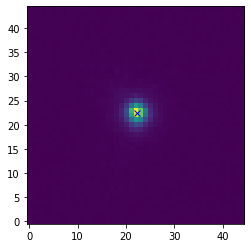

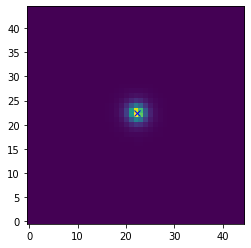

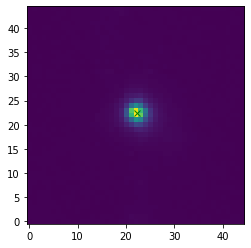

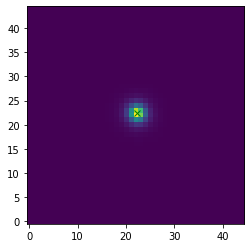

HE1126-0407
11 11
[975.1641567720682, 10.859055435397998, 11.099486386583553, 0.31027690100825767, 0.3050856277040988, -0.010456571712620245, 2.4972804215705118, 1.7859466195151885, 1.8201561311727432, -0.5549922206069953, 2.0202723592274134, 2.058970341613464] [1.28056682e+01 3.78477184e-03 3.94808929e-03 4.87402402e-03
 4.90764242e-03 1.46162815e-03 1.31379324e-02 1.41812020e-02
 1.45966552e-02 6.13083192e-02 1.07383875e-02 1.11005625e-02]
[44.28714335 10.91705677 11.09240171] [0.47056115 0.01251404 0.01266951]
[123.88305149  11.0575173   11.42373687] [0.51055818 0.00391126 0.00591481]


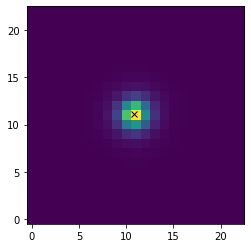

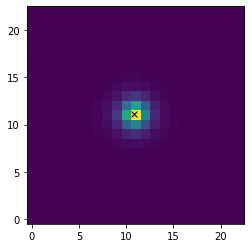

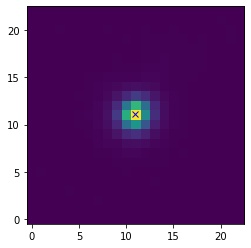

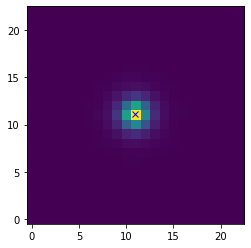

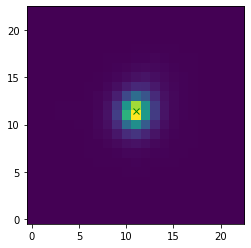

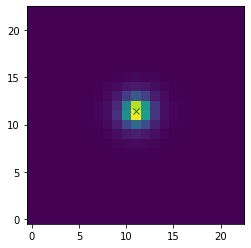

HE1237-0504
22 22
[177.0270482492518, 21.594899242831985, 22.265561824046248, 0.15786424245860123, 0.16165916245851195, 0.007289771317005203, 2.3129146408445362, 2.4702964476761493, 2.5346730660321395, -0.545409711646419, 2.9205317734711076, 2.9966416507104] [4.59097469e-01 1.60909053e-03 1.88120377e-03 9.34914243e-04
 9.90153158e-04 3.87415035e-04 6.08446121e-03 7.51587151e-03
 7.65647025e-03 2.00579876e-02 4.96236642e-03 5.07342825e-03]
[27.80605623 21.39275615 22.23028009] [0.07785743 0.00453256 0.00504187]
[78.00972913 22.04643109 22.34120795] [0.09718185 0.00234322 0.00210154]


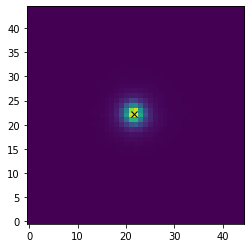

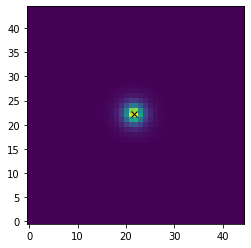

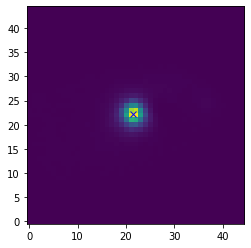

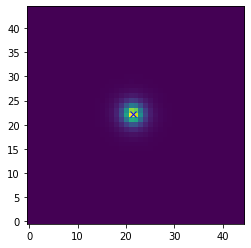

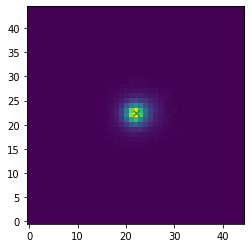

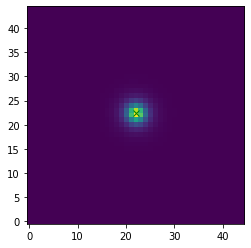

HE1248-1356
22 22
[10.54800150732227, 22.244165077803398, 21.609734505087854, 0.10306500898577545, 0.09501648015894326, -0.0035413687592077605, 3.5047908833178503, 3.1092907433309502, 3.2505219874815237, -0.20725427396625548, 2.908034341852684, 3.0401240504183313] [0.49805502 0.03347688 0.03102089 0.0215811  0.02038138 0.00544237
 0.47880082 0.32466863 0.33505609 0.28452369 0.0977762  0.09814809]
[ 9.05180515 22.3071324  21.46813381] [0.48656725 0.13417065 0.10203462]
[18.68837072 22.54034893 21.5450901 ] [2.59246684 0.26734602 0.2020823 ]


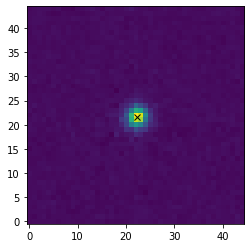

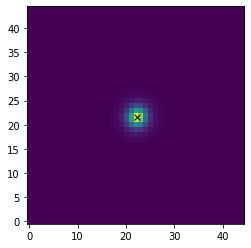

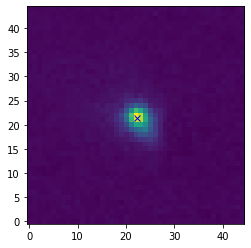

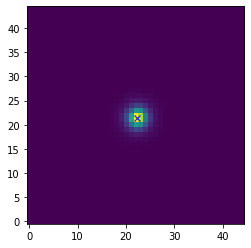

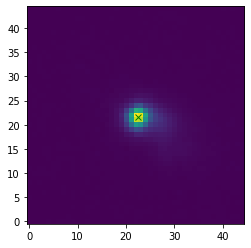

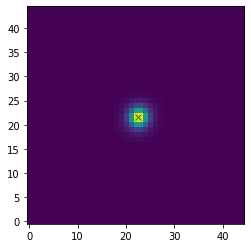

HE1330-1013
22 22
[18.836392891683083, 21.60476386189563, 21.866267314905663, 0.10393285520581443, 0.09860901557109072, 0.003162610507549475, 2.2591370921337037, 3.0954098170952897, 3.191538521286338, 0.268015366516176, 3.7098227710255287, 3.8250322188303363] [0.3365235  0.01201119 0.01434643 0.00465434 0.00454351 0.00155079
 0.04490064 0.06663105 0.07252628 0.13333348 0.04190174 0.04841755]
[ 1.19445044 21.46397141 22.04150136] [0.03019721 0.05524512 0.06427629]
[ 2.963108   21.84996805 21.61446095] [0.10893953 0.09296854 0.10445275]


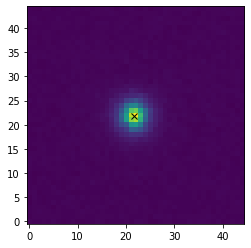

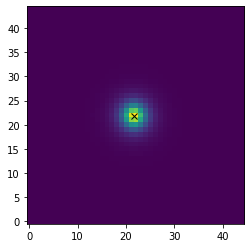

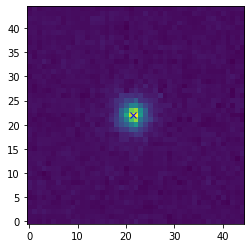

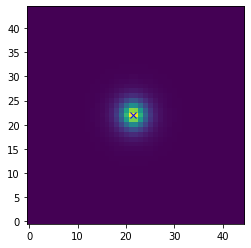

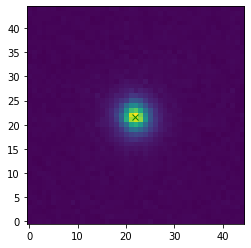

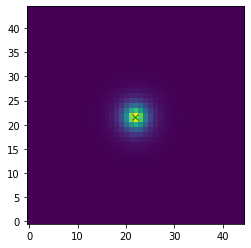

HE1353-1917
22 23
[15.864254174356281, 22.521694662310225, 21.64482592010316, 0.06384051802473939, 0.06671585729126107, -0.002428137286671019, 2.8196235098568048, 3.858735108196296, 3.971617882708654, 0.3506373731899334, 4.074077204160211, 4.1932595593849324] [1.46237374 0.041109   0.05259741 0.0095723  0.01052155 0.00243463
 0.17993805 0.29970263 0.29680747 0.39588725 0.17918948 0.17498699]
[ 3.46036862 25.60934304 16.98815605] [0.03991905 0.05352146 0.05248117]
[ 6.06438943 22.42169941 23.03105141] [0.03505191 0.02535459 0.05024739]


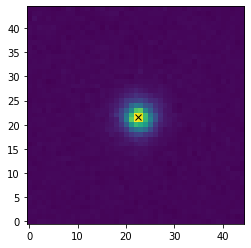

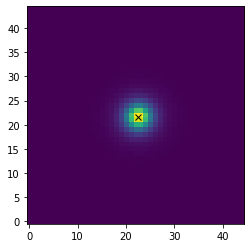

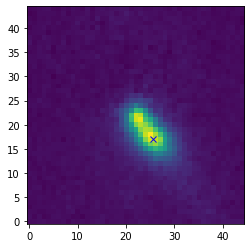

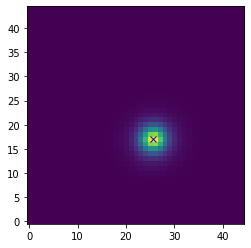

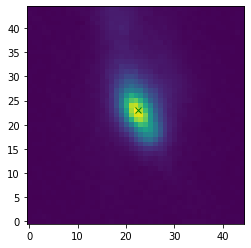

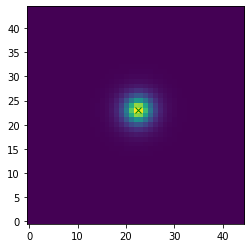

HE1417-0909
11 11
[99.25194043483023, 11.20072351554444, 11.161368492288736, 0.3087442981922873, 0.29117168589311787, 0.021043395695117744, 2.527982697767305, 1.7855268394217116, 1.8690768081583349, 0.43751834966309594, 2.0057261331328444, 2.0995798641536294] [0.88793965 0.00380973 0.00421117 0.00657079 0.00639285 0.0022056
 0.0257545  0.01921797 0.02061624 0.03844249 0.0109354  0.01208171]
[24.43713441 11.28031191 11.07946037] [0.27766417 0.01254291 0.01329387]
[43.01333594 11.18469708 11.20312057] [0.2271453  0.00678043 0.0072738 ]


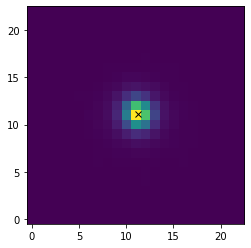

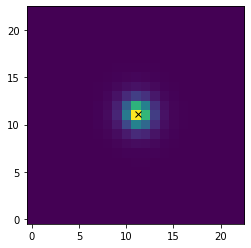

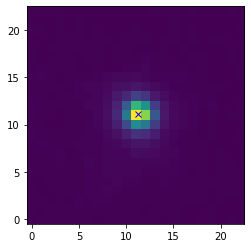

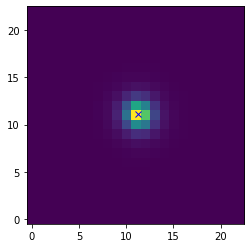

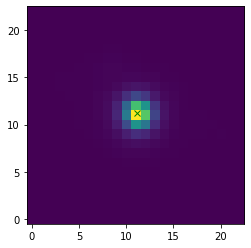

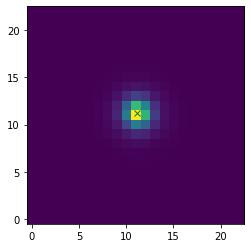

HE2128-0221
22 22
[8.794543591840906, 21.65757670672515, 21.454480574571154, 0.08899435162409643, 0.086266151763913, 0.0017398306943750214, 2.582414611512444, 3.3473447541061665, 3.409726361833669, 0.28384741934407015, 3.714701617082279, 3.7839293411812935] [0.08952762 0.00918861 0.00943745 0.00299716 0.0030221  0.00091068
 0.047577   0.05719074 0.06015916 0.19221866 0.02770369 0.03039379]
[ 2.64162129 21.62608919 21.62473985] [0.04385823 0.03415231 0.03181631]
[ 5.06810903 21.69876433 21.68160194] [0.05174726 0.01941077 0.02525046]


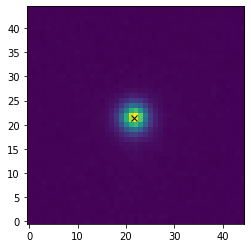

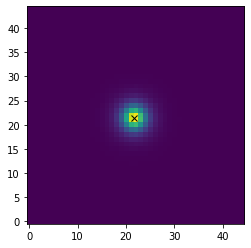

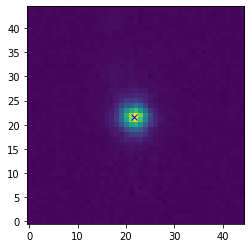

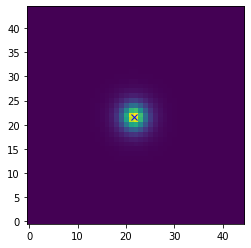

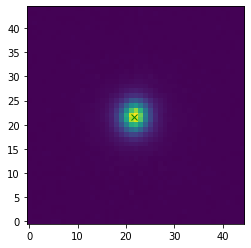

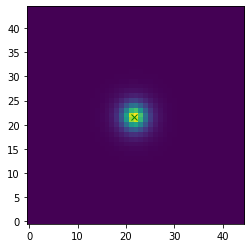

HE2211-3903
22 22
[41.18429495592451, 22.365452325360632, 21.825607445973795, 0.15421182865675828, 0.14361952847332715, -0.007401026065286728, 2.812122796390416, 2.5369227761349222, 2.6494849829355993, -0.30493237153445535, 2.682526777146739, 2.8015493728197445] [0.38966537 0.00632252 0.00612978 0.00466018 0.0039859  0.00187913
 0.04538607 0.03878347 0.03660028 0.06826851 0.02047034 0.01668388]
[ 0.64615294 22.57276652 22.14109908] [0.0542279  0.17566011 0.1144673 ]
[13.82496901 22.33201121 22.01464817] [0.05164895 0.00755563 0.00509726]


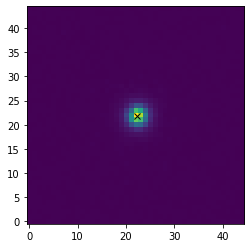

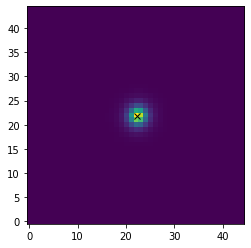

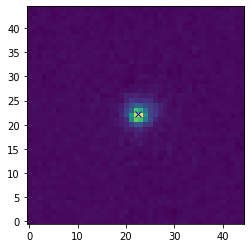

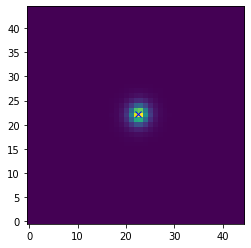

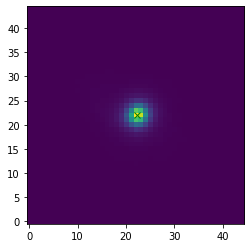

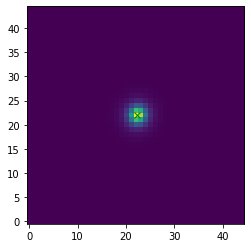

HE2222-0026
22 22
[16.69110688180359, 21.84381515822666, 21.94765776340301, 0.10374536149072387, 0.10649940617395937, -0.00417279662976944, 2.4417876867225083, 3.048238889853881, 3.1216099228663037, 0.4937117510797638, 3.4929070472500627, 3.576981231568797] [0.30716831 0.01164429 0.01103881 0.00413617 0.00448604 0.00136541
 0.04367478 0.06436881 0.06332789 0.21921956 0.04093323 0.03832259]
[ 0.83604973 21.91900665 22.11585546] [0.07990338 0.16623538 0.17254542]
[ 2.98715479 21.81706345 22.02700025] [0.03870401 0.02583426 0.02562464]


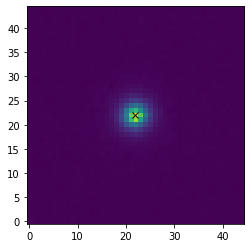

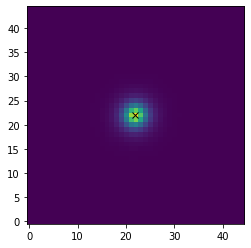

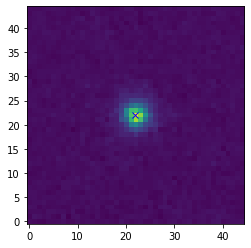

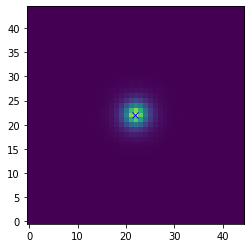

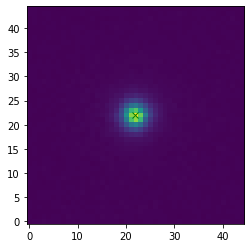

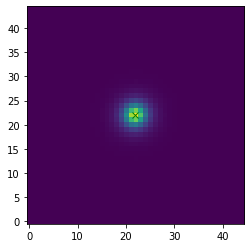

HE2233+0124
11 11
[46.89630064912345, 10.98263194088812, 10.967025928691308, 0.16489839678866222, 0.1558628102269701, -0.012500928079466385, 3.254129392070039, 2.439076257761824, 2.5593252717578356, -0.47246805083088034, 2.3767736317628723, 2.493951061046477] [3.15086803 0.03127246 0.03176777 0.02281935 0.02075612 0.00888849
 0.24448726 0.17554699 0.17690721 0.35543168 0.08267434 0.0793374 ]
[ 2.61445039 11.02779865 10.99153664] [0.2280592  0.09196691 0.09924278]
[ 9.46487312 10.87566308 10.99523666] [0.30789152 0.03335229 0.05142825]


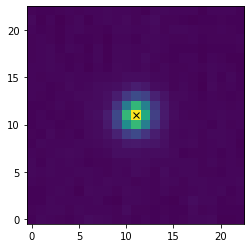

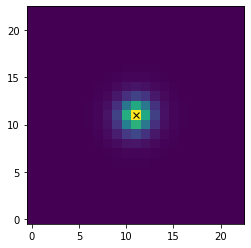

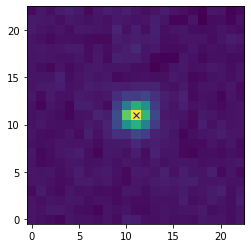

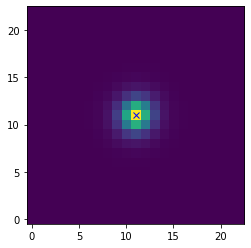

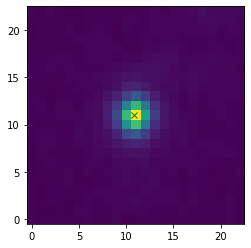

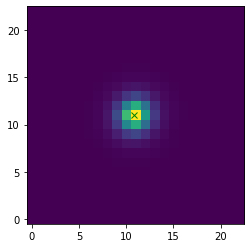

HE2302-0857
22 22
[143.10223642661057, 21.966969574258126, 21.804077350137213, 0.10750971768429055, 0.10482397974743923, 0.0036456131289212433, 2.4006001293038146, 3.036850914518827, 3.102318454908747, 0.4679295382628389, 3.5140629104844874, 3.589818046973074] [2.99597907e+00 1.16292451e-02 1.06598424e-02 3.53316331e-03
 3.34679835e-03 1.04744114e-03 2.74913780e-02 4.80711950e-02
 5.04397598e-02 1.29515253e-01 3.50486306e-02 3.76150630e-02]
[30.98045896 22.5042314  21.89648668] [0.39910849 0.03681645 0.03309474]
[132.35951997  21.21801912  21.53557214] [0.39931894 0.00946754 0.00604284]


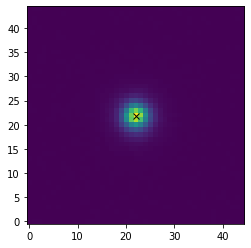

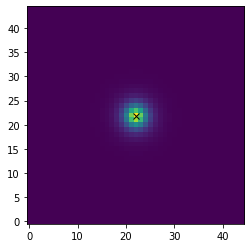

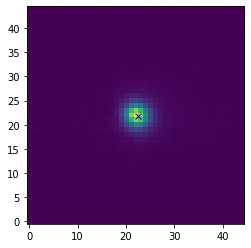

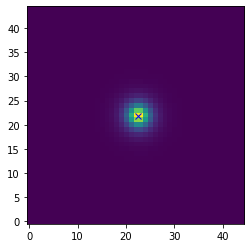

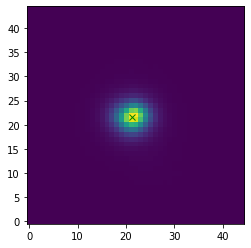

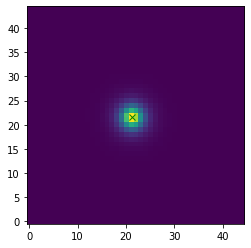

In [10]:
z = {"HE0021-1819":0.053197,"HE0040-1105":0.041692,"HE0108-4743":0.02392,"HE0114-0015":0.04560
    ,"HE0119-0118":0.054341,"HE0212-0059":0.026385,"HE0224-2834":0.059800,"HE0227-0913":0.016451,"HE0232-0900":0.043143
    ,"HE0253-1641":0.031588,"HE0345+0056":0.031,"HE0351+0240":0.036,"HE0412-0803":0.038160,"HE0429-0247":0.042009
    ,"HE0433-1028":0.035550,"HE0853+0102":0.052,"HE0934+0119":0.050338,"HE1011-0403":0.058314,"HE1017-0305":0.049986
    ,"HE1029-1831":0.040261,"HE1107-0813":0.058,"HE1108-2813":0.024013,"HE1126-0407":0.061960,"HE1237-0504":0.009
    ,"HE1248-1356":0.01465,"HE1330-1013":0.022145,"HE1353-1917":0.035021,"HE1417-0909":0.044,"HE2128-0221":0.05248
    ,"HE2211-3903":0.039714,"HE2222-0026":0.059114,"HE2233+0124":0.056482,"HE2302-0857":0.046860}

objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])

HE0021-1810
11 11
[16.690087287554324, 11.334808970178191, 10.686440876725687, 0.2488044689801188, 0.2794056439052608, -0.01285304902294586, 2.4979759947767457, 1.8874628821246853, 2.010036528409122, 0.1988217119109096, 2.1347676578747334, 2.273401513021723] [6.52834652e+00 1.88001456e-01 1.55699565e-01 1.94050454e-01
 2.63086654e-01 1.06320946e-01 1.03011530e+03 3.28898422e+01
 4.54001167e+01 4.20569628e-01 5.24511042e-01 7.04601764e-01]
[19.21181552 11.19700987 10.74089033] [0.3853749  0.02468581 0.02997259]
[11.71063362 11.28653049 10.77322655] [0.52272509 0.04827477 0.0720248 ]


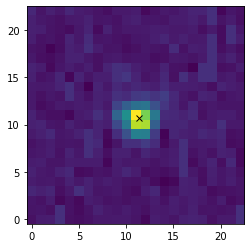

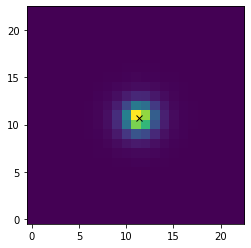

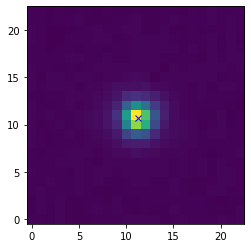

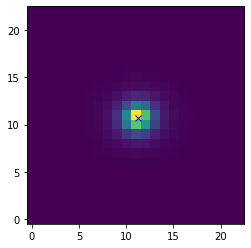

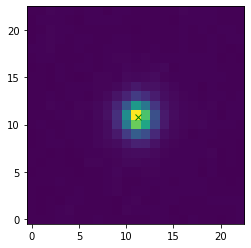

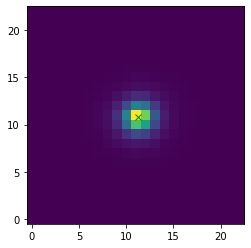

In [9]:
z = {"HE0021-1810":0.05352}

objs = z.keys()

for obj in objs:
    (Hb_blr_br_data,OIII_br_data,OIII_nr_data,amp_Hb_blr_br,amp_OIII_br,amp_OIII_nr,Hb_blr_br_err,OIII_br_err,OIII_nr_err) = flux_data_err(obj)
    box_size = np.shape(Hb_blr_br_data)[1]  
    y, x = np.mgrid[:box_size, :box_size]
    xy=(x,y)
    algorithm_script(obj,z[obj])